# The Variational Quantum Linear Solver for Redundant Calibration

In [1]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info.operators import Operator
from qiskit import Aer, transpile, assemble
import math
import random
import numpy as np
from scipy.optimize import minimize

from vqls_redcal_utils import get_antnennas_response

## 1. Redundant Calibration

We consider here the case of 5 antennas that are positionned in a row. The positions of the antennas are given by :

In [2]:
n_ant = 5
xpos = np.linspace(-2, 2, n_ant)[:,None]

The magnitude matrix is in this case given by :

In [3]:
Mmag = np.matrix(
    [[1, 1, 0, 0, 0, 1, 0, 0],     # baseline type 1 (4 rows)
     [0, 1, 1, 0, 0, 1, 0, 0],
     [0, 0, 1, 1, 0, 1, 0, 0],
     [0, 0, 0, 1, 1, 1, 0, 0],
     [1, 0, 1, 0, 0, 0, 1, 0],     # baseline type 2 (3 rows)
     [0, 1, 0, 1, 0, 0, 1, 0],
     [0, 0, 1, 0, 1, 0, 1, 0],
     [1, 0, 0, 1, 0, 0, 0, 1],     # baseline type 3 (2 row)
     [0, 1, 0, 0, 1, 0, 0, 1],
     [1, 0, 0, 0, 0, 0, 0, 0]])    # magnitude constraint

The redundant calibration is then reduced to solving the least square problem [https://arxiv.org/pdf/1004.0156.pdf]

$$
M_{mag} \theta = b
$$

where $b$ is given by the response of the antennas. For convenience we have packaged that response in a small method 

In [4]:
b = get_antnennas_response(xpos)

## 2. Variational Quantum Linear Solver

The Variational Quantum Linear Solver, or the VQLS is a variational quantum algorithm that utilizes VQE in order to solve systems of linear equations more efficiently than classical computational algorithms. Specifically, if we are given some matrix $\textbf{A}$, such that $\textbf{A} |\textbf{x}\rangle \ = \ |\textbf{b}\rangle$, where $|\textbf{b}\rangle$ is some known vector, the VQLS algorithm is theoretically able to find a normalized $|x\rangle$ that is proportional to $|\textbf{x}\rangle$, which makes the above relationship true.

The output of this algorithm is identical to that of the HHL Quantum Linear-Solving Algorithm, except, while HHL provides a much more favourable computation speedup over VQLS, the variational nature of our algorithm allows for it to be performed on NISQ quantum computers, while HHL would require much more robust quantum hardware, and many more qubits.

The details of the algorithm can be found in the original paper :

"Variational Quantum Linear Solver: A Hybrid Algorithm for Linear Systems", written by Carlos Bravo-Prieto, Ryan LaRose, M. Cerezo, Yiğit Subaşı, Lukasz Cincio, and Patrick J. Coles, which is available at [this](https://arxiv.org/abs/1909.05820) link.

And this implementation is largely based on the Qiskit tutorial

https://qiskit.org/textbook/ch-paper-implementations/vqls.html



## 3. Adapting the Redcal problem to VQLS

One of the main complication of VQLS for redundant calibration is that the matrix $\textbf{A}$ must be decomposed as a sum of unitary matrices :

$$A \ = \ \displaystyle\sum_{n} c_n \ A_n$$

The matrix $M_{mag}$ is not even square which makes it difficult to 
apply VQLS to Redcal.

### Transforming a least square to a linear system

In order to be able to use VQLS for redundant calibration we can manipulate our least square problem as followed :

$$ M_{mag} \theta = b $$

Multiplying on both sides by $M_{mag}^{\dagger}$ one obtain:

$$ M_{mag}^{\dagger} M_{mag} \theta = M_{mag}^{\dagger} b $$

The matrix $A = M_{mag}^{\dagger} M_{mag}$ is now symmetric which is a good start to find a unitary decomposition of it. One then  obtain the linear system

$$ A \theta = \tilde{b} $$

with $\tilde{b} = M_{mag}^{\dagger} b$

In [5]:
A = Mmag.T@Mmag
print(A)

[[4 1 1 1 0 1 1 1]
 [1 4 1 1 1 2 1 1]
 [1 1 4 1 1 2 2 0]
 [1 1 1 4 1 2 1 1]
 [0 1 1 1 3 1 1 1]
 [1 2 2 2 1 4 0 0]
 [1 1 2 1 1 0 3 0]
 [1 1 0 1 1 0 0 2]]


In [6]:
btilde = Mmag.T@b
print(btilde)

[[ 2.09637337e-01]
 [ 4.77121348e-01]
 [ 4.38885071e-04]
 [ 3.35517577e-01]
 [ 4.97495908e-01]
 [-2.78687835e-01]
 [ 2.18965491e-01]
 [ 8.19827872e-01]]


### Unitary decomposition 

Unitary decomposition of matrices is currently an active topic of research given the importance of such decompoisition in quantum computing See for example [this](https://arxiv.org/pdf/2101.02993.pdf).

While it is difficult at the moment to find the best decomposition of our matrix $A$, we can rely for the moment on techniques explained [here](https://math.stackexchange.com/questions/1710247/every-matrix-can-be-written-as-a-sum-of-unitary-matrices/1710390#1710390), to decompose our matrix in 4 unitary matrices.

In this example the contribution of the last two matrices cancel each other and we can therefore limit the decomposition to the 2 unitary matrices

In [7]:
from unitary_decomp import unitary_decomposition, unitary_recomposition
cAn, An = unitary_decomposition(A)
cAn, An = cAn[:2], An[:2]
print(unitary_recomposition(cAn, An))

[[4.+0.j 1.+0.j 1.+0.j 1.+0.j 0.+0.j 1.+0.j 1.+0.j 1.+0.j]
 [1.+0.j 4.+0.j 1.+0.j 1.+0.j 1.+0.j 2.+0.j 1.+0.j 1.+0.j]
 [1.+0.j 1.+0.j 4.+0.j 1.+0.j 1.+0.j 2.+0.j 2.+0.j 0.+0.j]
 [1.+0.j 1.+0.j 1.+0.j 4.+0.j 1.+0.j 2.+0.j 1.+0.j 1.+0.j]
 [0.+0.j 1.+0.j 1.+0.j 1.+0.j 3.+0.j 1.+0.j 1.+0.j 1.+0.j]
 [1.+0.j 2.+0.j 2.+0.j 2.+0.j 1.+0.j 4.+0.j 0.+0.j 0.+0.j]
 [1.+0.j 1.+0.j 2.+0.j 1.+0.j 1.+0.j 0.+0.j 3.+0.j 0.+0.j]
 [1.+0.j 1.+0.j 0.+0.j 1.+0.j 1.+0.j 0.+0.j 0.+0.j 2.+0.j]]


### Creation of the $\tilde{b}$ vector

VQLS aslo require an operator that creates the rhs of the linear system from the $|0\rangle$ state. In other words we define an operator $U_b$ so that :

$$
U_b|0\rangle = |\tilde{b}\rangle
$$

We do that by using Qiskit to create a circuit, initialize the state of the circuit to $|\tilde{b}\rangle$ and extract the matrix of the circuit. There might be better ways of doing this.

In [8]:
from get_b import get_b_unitmatrix
norm_btilde, Ub_mat = get_b_unitmatrix(btilde, 3, decimals=12)
print(Ub_mat)

[[ 1.75344488e-01+0.j -3.99072988e-01-0.j -1.12888267e-01-0.j
   2.56926571e-01+0.j -2.89227653e-01-0.j  6.58263883e-01+0.j
   1.86207213e-01+0.j -4.23795865e-01-0.j]
 [ 3.99072988e-01+0.j  1.75344488e-01+0.j -2.56926571e-01-0.j
  -1.12888267e-01-0.j -6.58263883e-01-0.j -2.89227653e-01-0.j
   4.23795865e-01+0.j  1.86207213e-01+0.j]
 [ 3.67091469e-04+0.j -2.80633014e-01-0.j  5.70187386e-04+0.j
  -4.35895187e-01-0.j -6.05510930e-04+0.j  4.62899227e-01+0.j
  -9.40514076e-04-0.j  7.19001454e-01+0.j]
 [ 2.80633014e-01+0.j  3.67091469e-04+0.j  4.35895187e-01+0.j
   5.70187386e-04+0.j -4.62899227e-01-0.j -6.05510930e-04+0.j
  -7.19001454e-01-0.j -9.40514076e-04-0.j]
 [ 4.16114641e-01+0.j -2.33099583e-01-0.j -6.19218335e-01-0.j
   3.46874446e-01+0.j  2.52269823e-01+0.j -1.41316802e-01-0.j
  -3.75401594e-01-0.j  2.10292901e-01+0.j]
 [-2.33099583e-01-0.j -4.16114641e-01-0.j  3.46874446e-01+0.j
   6.19218335e-01+0.j -1.41316802e-01-0.j -2.52269823e-01-0.j
   2.10292901e-01+0.j  3.75401594e-01+0.j

## 4. Qiskit Implementation

### Wave function Ansatz

VQLS works by optimizing a wave function ansatz $|\psi(\alpha)\rangle$ that depends on variational parameters $\alpha$ and that should approximate the solution of the linear system, i.e. $|\psi(\alpha)\rangle\approx|\theta\rangle$ in our case.

The creation of this wave function ansatz is done through a module $V(\alpha)$ that acts as follows:

$$
V(\alpha)|0\rangle = |\psi(\alpha)\rangle
$$

Many possibilities exists to define $V(\alpha)$. We use here a simple module described in the original paper

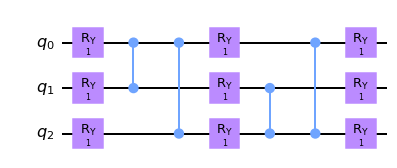

In [9]:
from vqls_redcal_utils import apply_fixed_ansatz
circ = QuantumCircuit(3)
apply_fixed_ansatz(circ, [0, 1, 2], [[1, 1, 1], [1, 1, 1], [1, 1, 1]])
circ.draw(output='mpl')

### Hadamard Test

VQLS relies on the Hadammard test to compute terms such as 

$$\langle \Phi | \Phi \rangle \ = \ \langle \psi(k) | A^{\dagger} A |\psi(k) \rangle \ = \ \langle 0 | V(k)^{\dagger} A^{\dagger} A V(k) |0\rangle \ = \ \langle 0 | V(k)^{\dagger} \Big( \displaystyle\sum_{n} c_n \ A_n \Big)^{\dagger} \Big( \displaystyle\sum_{n} c_n \ A_n \Big) V(k) |0\rangle$$



<br>



$$\Rightarrow \ \langle \Phi | \Phi \rangle \ = \ \displaystyle\sum_{m} \displaystyle\sum_{n} c_m^{*} c_n \langle 0 | V(k)^{\dagger} A_m^{\dagger} A_n V(k) |0\rangle$$

As explained in the original paper the hadamard test uses an auxiliary qbit that controls the applications of the $A_n$ and $A_m^\dagger$ operators, in other words:

$$
A_m |0\rangle|\psi(\alpha) = |0\rangle|\psi(\alpha)\rangle
$$

and

$$
A_m |1\rangle|\psi(\alpha) = |1\rangle A_m|\psi(\alpha)\rangle
$$

We therefore need to define these controlled operators for the $A_n$ matrices and their conjugate transpose

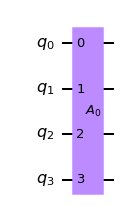

In [10]:
from vqls_redcal_utils import get_controlled_operator_matrix, apply_controlled_gate

ctrl_An = get_controlled_operator_matrix(An, 0, [1,2,3])
ctrl_An_dagger = get_controlled_operator_matrix([np.conjugate(a).T for a in An], 0, [1,2,3])

circ = QuantumCircuit(4)
apply_controlled_gate(circ, ctrl_An[0], 0, [1,2,3], name='$A_0$')
circ.draw(output='mpl')

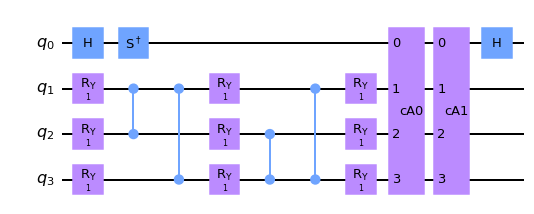

In [11]:
# Creates the Hadamard test
from vqls_redcal_utils import hadammard_test
circ = QuantumCircuit(4)
hadammard_test(circ, [ctrl_An[0], ctrl_An_dagger[1]],  ['cA0', 'cA1'], 
               [1, 2, 3], 0, [[1, 1, 1], [1, 1, 1], [1, 1, 1]], imag=True)
circ.draw(output='mpl')

### Computing  $|\langle b | \Phi \rangle|^2$

VQLS also relies on the calculation of the term :

$$|\langle b | \Phi \rangle|^2 \ = \ \displaystyle\sum_{m} \displaystyle\sum_{n} c_m c_n \langle 0 | U^{\dagger} A_n V(k) | 0 \rangle \langle 0 | U^{\dagger} A_m V(k) | 0 \rangle$$


There is a sophisticated way of solving for this value, using a newly-proposed subroutine called the **Hadamard Overlap Test** (see cited paper), but we will just be using a standard Hadamard Test, where we control each matrix. This unfortunately requires the use of an extra auxiliary qubit. We essentially just place a control on each of the gates involved in the auxiliary, the $|b\rangle$ preparation unitary, and the $A_n$ unitaries. 

We already have the controlled version of the $A_n$ operators. The circuit of the **controlled** wave function ansatz can be obtained via : 


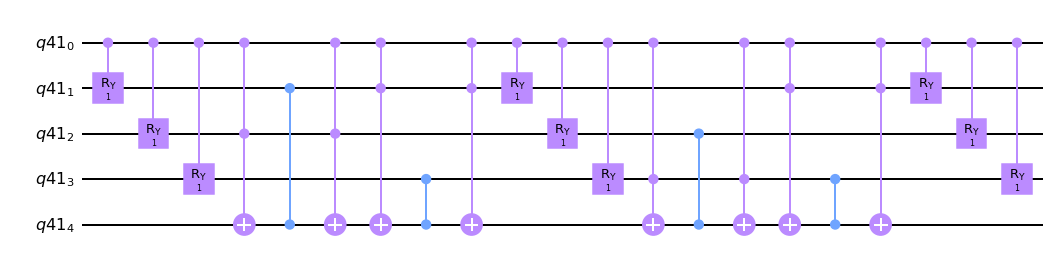

In [12]:
# Creates controlled anstaz for calculating |<b|psi>|^2 with a Hadamard test
from vqls_redcal_utils import apply_control_fixed_ansatz
q_reg = QuantumRegister(5)
circ = QuantumCircuit(q_reg)
apply_control_fixed_ansatz(circ, [1, 2, 3], [[1, 1, 1], [1, 1, 1], [1, 1, 1]], 0, q_reg)
circ.draw(output='mpl')

The circuit that make a controlled application of the right hand side operator is obtained in the same way as the controlled version of the $A_n$ matrices:

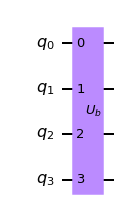

In [13]:
ctrl_Ub_mat = get_controlled_operator_matrix([Ub_mat], 0, [1,2,3])[0].real

circ = QuantumCircuit(4)
apply_controlled_gate(circ, ctrl_Ub_mat, 0, [1,2,3], name='$U_b$')
circ.draw(output='mpl')

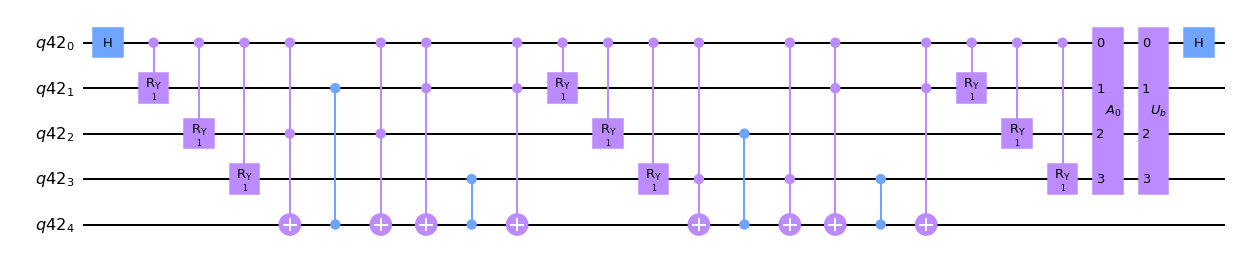

In [14]:
from vqls_redcal_utils import special_hadammard_test

q_reg = QuantumRegister(5)
circ = QuantumCircuit(q_reg)
special_hadammard_test(circ, ctrl_An[0], '$A_0$', ctrl_Ub_mat, 
                       [1, 2, 3], 0, 
                       [[1, 1, 1], [1, 1, 1], [1, 1, 1]], 
                       q_reg)
circ.draw(output='mpl')

In [15]:
# Create the controlled Hadamard test, for calculating <psi|psi>

def special_had_test(op_mat, op_name, cub_mat, qubits, auxiliary_index, parameters, reg, imag=False):

    circ.h(auxiliary_index)
    
    if imag:
        circ.sdg(auxiliary_index)

    control_fixed_ansatz(qubits, parameters, auxiliary_index, reg)
    
    apply_controlled_gate(op_mat, 0, [1,2,3],op_name)
    
    control_b(cub_mat, 0, [1,2,3])
    
    circ.h(auxiliary_index)

q_reg = QuantumRegister(5)
circ = QuantumCircuit(q_reg)
special_had_test(cA0_mat, 'A0', cub_mat, [1, 2, 3], 0, [[1, 1, 1], [1, 1, 1], [1, 1, 1]], q_reg)
circ.draw(output='mpl')

NameError: name 'cA0_mat' is not defined

In [ ]:
from get_b import get_b_unitmatrix

def control_b(ub, auxiliary, qubits):
    
    qc1 = QuantumCircuit(4, name='b')
    op = Operator(ub)
    qc1.append(op,[auxiliary] + qubits)
    circ.append(qc1,[auxiliary] + qubits)
    

norm_btilde = np.linalg.norm(btilde) 
btilde /= norm_btilde
btilde = np.asarray(btilde).flatten()

ub = get_b_unitmatrix(btilde, 3, decimals=12)
cub_mat = np.eye(2**4)
cub_mat[1::2,1::2] = ub.real

cub_mat_dagger = np.eye(2**4)
cub_mat_dagger[1::2,1::2] = ub.real.T

circ = QuantumCircuit(4)
control_b(cub_mat, 0, [1,2,3])
circ.draw(output='mpl')

In [ ]:
## def diag(x):
    return np.asmatrix(np.diag(x))

xpos = np.linspace(-2, 2, 5)[:,None]
n_ant = 5
l = np.r_[-0.5, 0.2, 0.7]
sigma = np.r_[0.8, 1, 0.4]

g  = 1 + 0.3 * (np.random.normal(size=n_ant) \
         + 1j * np.random.normal(size=n_ant))

freq = 150e6    # measurement frequency in MHz
c = 2.99792e8   # speed of light in m/s
A = np.matrix(np.exp(-(2 * np.pi * 1j * freq / c) * (xpos * l)))

R = diag(g) @ A @ diag(sigma) @ A.H @ diag(g).H

Mmag = np.matrix(
    [[1, 1, 0, 0, 0, 1, 0, 0],     # baseline type 1 (4 rows)
     [0, 1, 1, 0, 0, 1, 0, 0],
     [0, 0, 1, 1, 0, 1, 0, 0],
     [0, 0, 0, 1, 1, 1, 0, 0],
     [1, 0, 1, 0, 0, 0, 1, 0],     # baseline type 2 (3 rows)
     [0, 1, 0, 1, 0, 0, 1, 0],
     [0, 0, 1, 0, 1, 0, 1, 0],
     [1, 0, 0, 1, 0, 0, 0, 1],     # baseline type 3 (2 row)
     [0, 1, 0, 0, 1, 0, 0, 1],
     [1, 0, 0, 0, 0, 0, 0, 0]])    # magnitude constriant


# sel = np.c_[6, 12, 18, 24, 11, 17, 23, 16, 22].T - 1
sel = [i + j * n_ant + j             # indexing row-major
       for i in range(1, n_ant - 1)  # from first off-diagonal
                                     # not including the corner element
       for j in range(n_ant - i)]    # the first off-diagonal has (n_ant - 1) elements
                                     # and continuing, one less each time

b = np.c_[np.log10(np.abs(R.flat[sel])),0].T

### Reformulating the least square as a linear system

Instead of solving the system $Ax = b$ where is not square we will solve :
$$
A^\dagger A x= A^\dagger b
$$

Where now the matrix $A_2=A^\dagger A$ is symmetric and we define $\tilde{b} = A^\dagger b$ 

We also decompose the $A_2$ matrix in a sum of unitary matrix so that :
$$
A_2 = c_0 A_2^{0} + c_1 A_2^{1} 
$$

In [ ]:
from unitary_decomp import unitary_decomposition

M2 = Mmag.T@Mmag
M2_unit_coeffs, M2_unit_mats = unitary_decomposition(M2)

A0 = M2_unit_mats[0]
c0 = M2_unit_coeffs[0]

A1 = M2_unit_mats[1]
c1 = M2_unit_coeffs[1]

btilde = Mmag.T@b


### Controlled operation of the unitary operation 
We have to create controlled operation of the unitary operation defining the matrix

In [ ]:
def apply_controlled_gate(mat, auxiliary, qubits, name=None):

    qc1 = QuantumCircuit(4, name=name)
    op = Operator(mat)
    qc1.append(op, [auxiliary] + qubits)
    circ.append(qc1, [auxiliary] + qubits)
    

cA0_mat = np.eye(2**4).astype('complex')
cA0_mat[1::2,1::2] = A0

cA1_mat = np.eye(2**4).astype('complex')
cA1_mat[1::2,1::2] = A1


cA0_mat_dag = np.eye(2**4).astype('complex')
cA0_mat_dag[1::2,1::2] = np.conjugate(A0).T

cA1_mat_dag = np.eye(2**4).astype('complex')
cA1_mat_dag[1::2,1::2] = np.conjugate(A1).T

cI_mat = np.eye(2**4).astype('complex')

circ = QuantumCircuit(4)
apply_controlled_gate(cA0_mat, 0, [1,2,3],'ctrl_A0')
circ.draw(output='mpl')


In [ ]:
# Creates the Hadamard test

def had_test(matrices, matnames, qubits, auxiliary_index, parameters, imag=False):

    circ.h(auxiliary_index)
    
    if imag:
        circ.sdg(auxiliary_index)
    
    apply_fixed_ansatz(qubits, parameters)

    for mat, name in zip(matrices, matnames):
        apply_controlled_gate(mat, auxiliary_index, qubits, name)
        
    circ.h(auxiliary_index)
    
circ = QuantumCircuit(4)
had_test([cA0_mat, cA1_mat],  ['cA0', 'cA1'], [1, 2, 3], 0, [[1, 1, 1], [1, 1, 1], [1, 1, 1]],imag=True)
circ.draw(output='mpl')

In [ ]:
circ = QuantumCircuit(4)
had_test([cA0_mat, cA1_mat],  ['cA0', 'cA1'], [1, 2, 3], 0, [[1, 1, 1], [1, 1, 1], [1, 1, 1]],imag=True)
circ.draw(output='mpl')

Notice the extra qubit, `q0_4`. This is an auxiliary, and allows us to create a $CCZ$ gate, as is shown in the circuit. Now, we also have to create the circuit for $U$. 



### Controlled creation of the rhs vector

Finally, we construct our new Hadamard test:

This is for the specific implementation when all of our parameters are set to $1$, and the set of gates $A_n$ is simply `[0, 0, 0]`, and `[0, 0, 1]`, which corresponds to the identity matrix on all qubits, as well as the $Z$ matrix on the third qubit (with my "code notation").

Now, we are ready to calculate the final cost function. This simply involves us taking the products of all combinations of the expectation outputs from the different circuits, multiplying by their respective coefficients, and arranging into the cost function that we discussed previously!

In [ ]:
# Implements the entire cost function on the quantum circuit

def calculate_cost_function(parameters):
    
    global opt

    overall_sum_1 = 0.0 + 0.0j
    
    parameters = [parameters[0:3], parameters[3:6], parameters[6:9]]

    for i in range(0, len(gate_set)):
        for j in range(0, len(conj_gate_set)):
            
            beta_ij = 0.0 + 0.0j
            
            for imag in [False, True]:

                global circ

                qctl = QuantumRegister(4)
                qc = ClassicalRegister(4)
                circ = QuantumCircuit(qctl, qc)

                backend = Aer.get_backend('aer_simulator')

                multiply = coefficient_set[i].conj()*coefficient_set[j]

                had_test([conj_gate_set[i], gate_set[j]], 
                         [conj_gate_name[i], gate_name[j]], 
                         [1, 2, 3], 0, parameters,
                         imag=imag)

                circ.save_statevector()
                t_circ = transpile(circ, backend)
                qobj = assemble(t_circ)
                job = backend.run(qobj)

                result = job.result()
                outputstate = result.get_statevector(circ, decimals=100)
                o = outputstate

                m_sum = 0
                for l in range (0, len(o)):
                    if (l%2 == 1):
                        n = o[l]*o[l].conj()
                        m_sum+=n
                     
                p01 = 1.0 - 2.0*m_sum
                
                if imag:
                    beta_ij += 1.0j * p01
                else:
                    beta_ij += p01
                    
            print(i,j,beta_ij)    
            overall_sum_1 += multiply*beta_ij
                
    print(overall_sum_1)
   
    overall_sum_2 = 0.0 + 0.0j

    for i in range(0, len(gate_set)):
        for j in range(0, len(gate_set)):
            for imag in [False, True]:

                multiply = coefficient_set[i]*np.conjugate(coefficient_set[j])
                mult = 1

                for extra in range(0, 2):

                    qctl = QuantumRegister(5)
                    qc = ClassicalRegister(5)
                    circ = QuantumCircuit(qctl, qc)

                    backend = Aer.get_backend('aer_simulator')

                    if (extra == 0):
                        special_had_test(gate_set[i], gate_name[i], 
                                         cub_mat_dagger, [1, 2, 3], 
                                         0, parameters, qctl,
                                         imag=imag)
                    if (extra == 1):
                        special_had_test(gate_set[j], gate_name[j], 
                                         cub_mat_dagger, [1, 2, 3], 
                                         0, parameters, qctl,
                                         imag=imag)

                    circ.save_statevector()    
                    t_circ = transpile(circ, backend)
                    qobj = assemble(t_circ)
                    job = backend.run(qobj)

                    result = job.result()
                    outputstate = result.get_statevector(circ, decimals=100)
                    o = outputstate

                    m_sum = 0
                    for l in range (0, len(o)):
                        if (l%2 == 1):
                            n = o[l]*o[l].conj()
                            m_sum+=n
                    
                    mult = mult*(1-(2*m_sum))

                if imag:
                    overall_sum_2 += multiply*mult*(-1.0j)
                else:
                    overall_sum_2 += multiply*mult
                    
    print(overall_sum_2)       
    print(1-(overall_sum_2/overall_sum_1))
    print('---------------')
    return 1-(overall_sum_2/overall_sum_1)

This code may look long and daunting, but it isn't! In this simulation, I'm taking a **numerical** approach, where I'm calculating the amplitude squared of each state corresponding to a measurement of the auxiliary Hadamard test qubit in the $1$ state, then calculating $P(0) \ - \ P(1) \ = \ 1 \ - \ 2P(1)$ with that information. This is very exact, but is not realistic, as a real quantum device would have to sample the circuit many times to generate these probabilities (I'll discuss sampling later). In addition, this code is not completely optimized (it completes more evaluations of the quantum circuit than it has to), but this is the simplest way in which the code can be implemented, and I will be optimizing it in an update to this tutorial in the near future.


In order to minimize the cost function, we use the COBYLA optimizer method, which we repeatedly applying. Our search space for parameters is determined by $\frac{k}{1000} \ k \ \in \ \{0, \ 3000\}$, which is initially chosen randomly. We will run the optimizer for $200$ steps, then terminate and apply the ansatz for our optimal parameters, to get our optimized state vector! In addition, we will compute some post-processing, to see if our algorithm actually works! In order to do this, we will apply $A$ to our optimal vector $|\psi\rangle_o$, normalize it, then calculate the inner product squared of this vector and the solution vector, $|b\rangle$! We can put this all into code as:

In [ ]:
coefficient_set = M2_unit_coeffs[:2]
sum_coefficient_set = np.sum(coefficient_set)
coefficient_set = [c/sum_coefficient_set for c in coefficient_set]

gate_set = [cA0_mat, cA1_mat]
gate_name = ['A0','A1']

conj_gate_set = [cA0_mat_dag, cA1_mat_dag]
conj_gate_name = ['A0dag','A1dag']

out = minimize(calculate_cost_function, x0=[float(random.randint(0,3000))/1000 for i in range(0, 9)], 
               method="COBYLA", options={'maxiter':200})
print(out)

out_f = [out['x'][0:3], out['x'][3:6], out['x'][6:9]]

circ = QuantumCircuit(3, 3)
apply_fixed_ansatz([0, 1, 2], out_f)
circ.save_statevector()

backend = Aer.get_backend('aer_simulator')
t_circ = transpile(circ, backend)
qobj = assemble(t_circ)
job = backend.run(qobj)

result = job.result()
o = result.get_statevector(circ, decimals=10)

In [ ]:
bb = btilde 
a3 = np.asarray(M2)
os = o/sum_coefficient_set
print(os)
x = np.linalg.solve(M2,btilde)
print(x)
print(np.linalg.norm(M2@os-btilde))
print((bb.dot(a3.dot(os)/(np.linalg.norm(a3.dot(os)))))**2)

As you can see, our cost function has achieved a fairly low value of `0.03273673575407443`, and when we calculate our classical cost function, we get `0.96776862579723`, which agrees perfectly with what we measured, the vectors $|\psi\rangle_o$ and $|b\rangle$ are very similar!

Let's do another test! This time, we will keep $|b\rangle$ the same, but we will have:

<br>



$$A \ = \ 0.55 \mathbb{I} \ + \ 0.225 Z_2 \ + \ 0.225 Z_3$$



Again, we run our optimization code:

In [ ]:
coefficient_set = [0.55, 0.225, 0.225]
gate_set = [[0, 0, 0], [0, 1, 0], [0, 0, 1]]

out = minimize(calculate_cost_function, x0=[float(random.randint(0,3000))/1000 for i in range(0, 9)], method="COBYLA", options={'maxiter':200})
print(out)

out_f = [out['x'][0:3], out['x'][3:6], out['x'][6:9]]

circ = QuantumCircuit(3, 3)
apply_fixed_ansatz([0, 1, 2], out_f)
circ.save_statevector()

backend = Aer.get_backend('aer_simulator')

t_circ = transpile(circ, backend)
qobj = assemble(t_circ)
job = backend.run(qobj)

result = job.result()
o = result.get_statevector(circ, decimals=10)

a1 = coefficient_set[2]*np.array([[1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [0,0,1,0,0,0,0,0], [0,0,0,1,0,0,0,0], [0,0,0,0,-1,0,0,0], [0,0,0,0,0,-1,0,0], [0,0,0,0,0,0,-1,0], [0,0,0,0,0,0,0,-1]])
a0 = coefficient_set[1]*np.array([[1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [0,0,-1,0,0,0,0,0], [0,0,0,-1,0,0,0,0], [0,0,0,0,1,0,0,0], [0,0,0,0,0,1,0,0], [0,0,0,0,0,0,-1,0], [0,0,0,0,0,0,0,-1]])
a2 = coefficient_set[0]*np.array([[1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [0,0,1,0,0,0,0,0], [0,0,0,1,0,0,0,0], [0,0,0,0,1,0,0,0], [0,0,0,0,0,1,0,0], [0,0,0,0,0,0,1,0], [0,0,0,0,0,0,0,1]])

a3 = np.add(np.add(a2, a0), a1)

b = np.array([float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8))])

print((b.dot(a3.dot(o)/(np.linalg.norm(a3.dot(o)))))**2)

Again, very low error, and the classical cost function agrees! Great, so it works!

Now, we have found that this algorithm works **in theory**. I tried to run some simulations with a circuit that samples the circuit instead of calculating the probabilities numerically. Now, let's try to **sample** the quantum circuit, as a real quantum computer would do! For some reason, this simulation would only converge somewhat well for a ridiculously high number of "shots" (runs of the circuit, in order to calculate the probability distribution of outcomes). I think that this is mostly to do with limitations in the classical optimizer (COBYLA), due to the noisy nature of sampling a quantum circuit (a measurement with the same parameters won't always yield the same outcome). Luckily, there are other optimizers that are built for noisy functions, such as SPSA, but we won't be looking into that in this tutorial. Let's try our sampling for our second value of $A$, with the same matrix $U$:

In [ ]:
#Implements the entire cost function on the quantum circuit (sampling, 100000 shots)

def calculate_cost_function(parameters):

    global opt

    overall_sum_1 = 0
    
    parameters = [parameters[0:3], parameters[3:6], parameters[6:9]]

    for i in range(0, len(gate_set)):
        for j in range(0, len(gate_set)):

            global circ

            qctl = QuantumRegister(5)
            qc = ClassicalRegister(1)
            circ = QuantumCircuit(qctl, qc)

            backend = Aer.get_backend('aer_simulator')
            
            multiply = coefficient_set[i]*coefficient_set[j]

            had_test(gate_set[i], gate_set[j], [1, 2, 3], 0, parameters)

            circ.measure(0, 0)

            t_circ = transpile(circ, backend)
            qobj = assemble(t_circ, shots=10000)
            job = backend.run(qobj)

            result = job.result()
            outputstate = result.get_counts(circ)

            if ('1' in outputstate.keys()):
                m_sum = float(outputstate["1"])/100000
            else:
                m_sum = 0

            overall_sum_1+=multiply*(1-2*m_sum)

    overall_sum_2 = 0

    for i in range(0, len(gate_set)):
        for j in range(0, len(gate_set)):

            multiply = coefficient_set[i]*coefficient_set[j]
            mult = 1

            for extra in range(0, 2):

                qctl = QuantumRegister(5)
                qc = ClassicalRegister(1)
                
                circ = QuantumCircuit(qctl, qc)

                backend = Aer.get_backend('aer_simulator')

                if (extra == 0):
                    special_had_test(gate_set[i], [1, 2, 3], 0, parameters, qctl)
                if (extra == 1):
                    special_had_test(gate_set[j], [1, 2, 3], 0, parameters, qctl)

                circ.measure(0, 0)

                t_circ = transpile(circ, backend)
                qobj = assemble(t_circ, shots=10000)
                job = backend.run(qobj)

                result = job.result()
                outputstate = result.get_counts(circ)

                if ('1' in outputstate.keys()):
                    m_sum = float(outputstate["1"])/100000
                else:
                    m_sum = 0

                mult = mult*(1-2*m_sum)
            
            overall_sum_2+=multiply*mult
            
    print(1-float(overall_sum_2/overall_sum_1))

    return 1-float(overall_sum_2/overall_sum_1)

In [ ]:
coefficient_set = [0.55, 0.225, 0.225]
gate_set = [[0, 0, 0], [0, 1, 0], [0, 0, 1]]

out = minimize(calculate_cost_function, x0=[float(random.randint(0,3000))/1000 for i in range(0, 9)], method="COBYLA", options={'maxiter':200})
print(out)

out_f = [out['x'][0:3], out['x'][3:6], out['x'][6:9]]

circ = QuantumCircuit(3, 3)
apply_fixed_ansatz([0, 1, 2], out_f)
circ.save_statevector()

backend = Aer.get_backend('aer_simulator')

t_circ = transpile(circ, backend)
qobj = assemble(t_circ)
job = backend.run(qobj)

result = job.result()
o = result.get_statevector(circ, decimals=10)

a1 = coefficient_set[2]*np.array([[1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [0,0,1,0,0,0,0,0], [0,0,0,1,0,0,0,0], [0,0,0,0,-1,0,0,0], [0,0,0,0,0,-1,0,0], [0,0,0,0,0,0,-1,0], [0,0,0,0,0,0,0,-1]])
a0 = coefficient_set[1]*np.array([[1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [0,0,-1,0,0,0,0,0], [0,0,0,-1,0,0,0,0], [0,0,0,0,1,0,0,0], [0,0,0,0,0,1,0,0], [0,0,0,0,0,0,-1,0], [0,0,0,0,0,0,0,-1]])
a2 = coefficient_set[0]*np.array([[1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], [0,0,1,0,0,0,0,0], [0,0,0,1,0,0,0,0], [0,0,0,0,1,0,0,0], [0,0,0,0,0,1,0,0], [0,0,0,0,0,0,1,0], [0,0,0,0,0,0,0,1]])

a3 = np.add(np.add(a2, a0), a1)

b = np.array([float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8)),float(1/np.sqrt(8))])

print((b.dot(a3.dot(o)/(np.linalg.norm(a3.dot(o)))))**2)

So as you can see, not amazing, our solution is still off by a fairly significant margin ($~3\%$ error isn't awful, but ideally, we want it to be **much** closer to 0). Again, I think this is due to the optimizer itself, not the actual quantum circuit. I will be making an update to this Notebook once I figure out how to correct this problem (likely with the introduction of a noisy optimizer, as I previously mentioned).

## 4. Acknowledgements

This implementation is based on the work presented in the research paper "Variational Quantum Linear Solver: A Hybrid Algorithm for Linear Systems", written by Carlos Bravo-Prieto, Ryan LaRose, M. Cerezo, Yiğit Subaşı, Lukasz Cincio, and Patrick J. Coles, which is available at [this](https://arxiv.org/abs/1909.05820) link.

Special thanks to Carlos Bravo-Prieto for personally helping me out, by answering some of my questions concerning the paper!

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table